### In this module we will run YOLO on our test set and analyze its outputs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from ultralytics import YOLO
import torch
import migKeyPoint.utils.YAMLtools as yt

In [2]:
conf = yt.load_configuration('../master_configuration.yaml')['yoloConf']

In [3]:
conf

{'project_dir': '/home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial',
 'pretrained_model_path': '../pretrained/linear/best.pt',
 'noise': False,
 'log_scale': False,
 'cameraX': 2048,
 'cameraY': 1152,
 'outputX': 512,
 'outputY': 288,
 'maxNumKeyPoints': 9,
 'GPU': True,
 'project': '/home/jeef/workspace/migKeyPoint/migKeyPoint/tutorial/models/linear',
 'suffix': '_linear'}

### Load test set

**In this document conf['project_dir'] will be the parent directory for most things**

In [4]:
'''Calling our testset dataframe df'''
df = pd.read_feather(conf['project_dir']+"/data/test%s.feather"%(conf['suffix']))

# Now let's evaluate YOLO on the test images

After training yolo it will create a directory called *runs/*. You'll need to navigate through runs and find the
desired model you trained. In the example below *train13/* is the directory that we're using. The *weights/* subdirectory contains two files, one called 'best' and the other called 'last'. 'best' is the saved weights file during the best performing epoch of training. It's typically best to use this file.

In [6]:
'''You may need to manually set the weights path. If you do multiple trainings in the same project
ultralytics will append version numbers to the directories where the weights are located...for instance
train2/ train3/ train/50, etc'''

from PIL import Image

#Directory of the test PNG images we created is determined by conf['suffix']

testpath = conf['project_dir']+'/datasets/test%s/images/'%(conf['suffix'])

#Create a sorted list of PIL images to pass into YOLO
images = [Image.open(testpath+val) for val in sorted(os.listdir(testpath))]
print('Performing YOLO inference\n')

#Load trained YOLO model weights. Where we look will depend on if the model is pretrained or not
if len(conf['pretrained_model_path']) != 0:
    try:
        weights_file = conf['pretrained_model_path']+'/best.pt'
        model = YOLO(weights_file)
        print(f"Found weights file at {weights_file}")
    except:
        print(f"Weights file not found at {weights_file} trying {conf['pretrained_model_path']}")
        try:
            weights_file = conf['pretrained_model_path']
            model = YOLO(weights_file)
            print(f"Found weights file at {conf['pretrained_model_path']}")
        except:
            raise OSError(f"Couldn't find a model at {weights_file}. Did you mean to use a pretrained_model path?")
else:
    weights_file = conf['project']+'/train/weights/best.pt'
    model = YOLO(weights_file)

#Perform YOLO inference on all images
results = model.predict(images,batch = len(images),verbose = False, workers = 1,imgsz=512,rect=True)
print("DONE")

Performing YOLO inference

Weights file not found at ../pretrained/linear/best.pt/best.pt trying ../pretrained/linear/best.pt
Found weights file at ../pretrained/linear/best.pt


### Let's take a closer look at the results file before analyzing

In [7]:
#The length of the results list should always be the same as the test dataframe
print(len(results),len(df))

#Looking through the results list, each entry has a boxes and keypoints object
results

113 113


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: ultralytics.engine.results.Keypoints object
 masks: None
 names: {0: 'ER', 1: 'NR', 2: 'Proton'}
 obb: None
 orig_img: array([[[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0],
         ...,
         [127,   0,   0],
         [127,   0,   0],
         [127,   0,   0]],
 
        [[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0],
         ...,
         [127,   0,   0],
         [127,   0,   0],
         [127,   0,   0]],
 
        [[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0],
         ...,
         [127,   0,   0],
         [127,   0,   0],
         [127,   0,   0]],
 
        ...,
 
        [[127,   0,   0],
         [127,   0,   0],
         [127,   0,   0],
         ...,
         [127,   0,   0],
         [127,   0,   0],
         [127,   0,   0]],
 
        [[127,   0,   0],
         [127,   0,   0],
 

In [8]:
#Now lets look at boxes and keypoints for the first image
print(results[0].boxes)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.8544], device='cuda:0')
data: tensor([[255.0000, 143.0000, 285.0000, 171.0000,   0.8544,   0.0000]], device='cuda:0')
id: None
is_track: False
orig_shape: (288, 512)
shape: torch.Size([1, 6])
xywh: tensor([[270., 157.,  30.,  28.]], device='cuda:0')
xywhn: tensor([[0.5273, 0.5451, 0.0586, 0.0972]], device='cuda:0')
xyxy: tensor([[255., 143., 285., 171.]], device='cuda:0')
xyxyn: tensor([[0.4980, 0.4965, 0.5566, 0.5938]], device='cuda:0')


In [9]:
#The above shows several options for boxes. The xyxyn format gives [xmin,ymin,xmax,ymax] of the bounding box
#normalized to 1. This is what we should use so we can upscale the box to the 2048 x 1152 image

results[0].boxes.xyxyn.cpu().numpy()

array([[    0.49805,     0.49653,     0.55664,     0.59375]], dtype=float32)

In [10]:
#It's possible that there can be more than one bounding box per image, let's check if any images identified more than
#one track. If they do, any additionalbounding boxes beyond the first would be a false positive

for i,res in enumerate(results):
    if len(res.boxes.xyxyn) > 1:
        print(i)

### Now lets take a look at the keypoints

In [11]:
results[0].keypoints

ultralytics.engine.results.Keypoints object with attributes:

conf: None
data: tensor([[[262.1754, 152.2441],
         [264.2993, 152.2934],
         [265.9500, 152.9436],
         [267.4672, 153.9116],
         [268.7760, 155.1026],
         [269.8266, 156.6676],
         [270.7451, 158.1566],
         [271.7108, 159.1951],
         [272.8501, 160.3807]]], device='cuda:0')
has_visible: False
orig_shape: (288, 512)
shape: torch.Size([1, 9, 2])
xy: tensor([[[262.1754, 152.2441],
         [264.2993, 152.2934],
         [265.9500, 152.9436],
         [267.4672, 153.9116],
         [268.7760, 155.1026],
         [269.8266, 156.6676],
         [270.7451, 158.1566],
         [271.7108, 159.1951],
         [272.8501, 160.3807]]], device='cuda:0')
xyn: tensor([[[0.5121, 0.5286],
         [0.5162, 0.5288],
         [0.5194, 0.5311],
         [0.5224, 0.5344],
         [0.5250, 0.5386],
         [0.5270, 0.5440],
         [0.5288, 0.5492],
         [0.5307, 0.5528],
         [0.5329, 0.5569]]], 

In [12]:
#the .xyn field contains the normalized keypoint coordinates so lets use these so we can scale them up to 2048 x 1152
#Let's quickly check if all 9 keypoints are found in each image

for i,res in enumerate(results):
    if len(res.keypoints.xyn[0]) != conf['maxNumKeyPoints']:
        print(i)

# Lets aggregate our keypoint and bounding box predictions into a dataframe so we can quantitatively compare them with truth

In [13]:
### The columns of interest are 'class_index', 'xBB', 'yBB', 'width',
### 'height', 'pkx', 'pky'; k \in [0,...,maxNumKeyPoints]
### We need to convert these back to the aspect ratio of the camera

xcols = ['xBB', 'width'] + ['p%sx'%(i) for i in range(0,conf['maxNumKeyPoints'])]
ycols = ['yBB', 'height'] + ['p%sy'%(i) for i in range(0,conf['maxNumKeyPoints'])]

for col in xcols:
    df[col] = df[col]*conf['cameraX']

for col in ycols:
    df[col] = df[col]*conf['cameraY']

### Our bounding box dimensions are [xmin,xmax,ymin,ymax] so lets make columns for these in our test dataframe too

In [14]:
'''Bounding box perimeters'''
df['xmin'] = np.round(df['xBB']-df['width']/2).astype('int')
df['xmax'] = np.round(df['xBB']+df['width']/2).astype('int')

df['ymin'] = np.round(df['yBB']-df['height']/2).astype('int')
df['ymax'] = np.round(df['yBB']+df['height']/2).astype('int')

### Now let's compile the YOLO results

In [15]:
'''We compile results into track-indexed data but will store the frame index so we can link back
to data indexed by image frame. Since we only had one track per frame in this example, there will be a one-to-one
correspondence between frame-indexed and track-indexed data. That will not be the case in general. 
The code below handles the general case.'''

yolo = pd.DataFrame() #YOLO results dataframe
xmin = []
xmax = []
ymin = []
ymax = []
pred = [] #class prediction, should be 0 (ER) for each event in this sample
prob = [] #class prediction confidence score between 0 and 1. 1 is most confident, 0 means the model has no idea
frameIndex = []
coords = {}

#Fill coords dictionary with lists of each keypoint
for i in range(0,conf['maxNumKeyPoints']):
    coords[i] = []
for i,res in enumerate(results):
    boxes = res.boxes.xyxyn.cpu().numpy() #tensor of all of the boxes converted to 4 x Nboxes numpy array
    points = res.keypoints.xyn.cpu().numpy() #tensor of all sets of key points as (1 x 2) x NkeyPointSets array 
    data = res.boxes.data.cpu().numpy() #to get class prediction and class confidence score
    for datum, box, point in zip(data,boxes,points): #loop through all boxes and sets of key points in frame i
        frameIndex.append(i) #frame index
        xmin.append(box[0]*conf['cameraX'])
        ymin.append(box[1]*conf['cameraY'])
        xmax.append(box[2]*conf['cameraX'])
        ymax.append(box[3]*conf['cameraY'])
        pred.append(datum[5])
        prob.append(datum[4])
        #grab each of the N key points to put into the coords[j] list these are still normalized
        for j,p in enumerate(point):
            coords[j].append(p)

In [16]:
'''Now we populate the yolo results dataframe'''
yolo['frame'] = frameIndex #frame number
yolo['xmin'] = xmin
yolo['xmax'] = xmax
yolo['ymin'] = ymin
yolo['ymax'] = ymax
yolo['pred'] = pred
yolo['prob'] = prob
for i in range(0,conf['maxNumKeyPoints']):
    yolo['p%s'%(i)] = coords[i]

In [17]:
'''Now lets change the pj"s to pjx and pjy and also convert to resolution of the camera'''
# Initialize an empty dictionary to hold the new columns
new_columns = {}

# Iterate over each of the keypoint columns in the DataFrame
for col in yolo.columns[int(-1*conf['maxNumKeyPoints']):]:
    # Extract x and y components from each column
    yolo[[f'{col}x', f'{col}y']] = pd.DataFrame(yolo[col].tolist(), index=yolo.index)
    # Drop the original column
    yolo.drop(columns=[col], inplace=True)
    
'''Scale pjx and pjy to aspect ratio of images'''
for i in range(0,conf['maxNumKeyPoints']):
    yolo['p%sx'%(i)] *= conf['cameraX']
    yolo['p%sy'%(i)] *= conf['cameraY']

### Let's compare YOLO's output to our original test set

In [18]:
#Test set (truth)
len(df)

113

In [19]:
#Test set (truth)
len(yolo)

113

In [20]:
'''From the two cells above we see that YOLO predicted two more tracks than there actually are so we need to
handle these properly. On real data we won"t know how many tracks there actually are per frame, so a good way to
handle this is to group YOLO"s output by frame number (this is the index of our truth test set) and then aggregate
the contents of YOLO"s output'''

grp = yolo.groupby('frame').agg(list).reset_index()
grp

,frame,xmin,xmax,ymin,ymax,pred,prob,p0x,p0y,p1x,...,p4x,p4y,p5x,p5y,p6x,p6y,p7x,p7y,p8x,p8y
0,0,[1020.0],[1140.0],[572.0000152587891],[684.0],[0.0],[0.8543708920478821],[1048.7017822265625],[608.9765014648438],[1057.1971435546875],...,[1075.10400390625],[620.4102783203125],[1079.3062744140625],[626.67041015625],[1082.980224609375],[632.626220703125],[1086.843017578125],[636.7802734375],[1091.4005126953125],[641.5228881835938]
1,1,[1020.0],[1144.0],[576.0],[700.0000076293945],[0.0],[0.8293460607528687],[1051.5081787109375],[666.0333251953125],[1057.5799560546875],...,[1070.426513671875],[634.951416015625],[1075.3992919921875],[629.12255859375],[1083.790771484375],[626.0253295898438],[1091.827880859375],[622.2349853515625],[1101.74658203125],[621.3421630859375]
2,2,[1020.0],[1160.0],[579.9999847412109],[696.0000228881836],[0.0],[0.8370804786682129],[1054.5009765625],[660.6275024414062],[1063.6085205078125],...,[1087.0782470703125],[646.4078979492188],[1093.5260009765625],[642.1982421875],[1100.287109375],[637.75732421875],[1107.160400390625],[633.2825927734375],[1114.63720703125],[629.6590576171875]
3,3,[1020.0],[1200.0],[576.0],[687.9999847412109],[0.0],[0.8399157524108887],[1063.4227294921875],[621.3827514648438],[1072.1102294921875],...,[1096.045166015625],[629.572265625],[1103.968994140625],[633.5074462890625],[1111.1064453125],[635.3568115234375],[1119.046630859375],[635.7977294921875],[1126.4749755859375],[636.6944580078125]
4,4,[1020.0],[1156.0],[572.0000152587891],[680.0000152587891],[0.0],[0.8297737240791321],[1060.8135986328125],[609.2832641601562],[1070.215576171875],...,[1091.90380859375],[615.9713745117188],[1097.078125],[622.23388671875],[1101.8948974609375],[629.079833984375],[1106.745361328125],[635.1165161132812],[1112.7685546875],[640.369873046875]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,108,[1020.0],[1184.0],[576.0],[671.9999771118164],[0.0],[0.8447384834289551],[1057.4029541015625],[613.1605224609375],[1069.483154296875],...,[1106.931884765625],[617.8588256835938],[1118.72998046875],[621.254638671875],[1128.7647705078125],[625.761962890625],[1139.358642578125],[630.0797729492188],[1150.618896484375],[633.536865234375]
109,109,[1028.0],[1172.0],[579.9999847412109],[656.0000381469727],[0.0],[0.83192378282547],[1060.92626953125],[626.768310546875],[1069.5213623046875],...,[1094.203857421875],[620.3670043945312],[1102.7330322265625],[619.1324462890625],[1111.0528564453125],[617.150390625],[1119.16357421875],[615.9425048828125],[1127.4656982421875],[614.2940063476562]
110,110,[1028.0],[1164.0],[576.0],[707.9999771118164],[0.0],[0.8475095629692078],[1072.0625],[613.6238403320312],[1083.6324462890625],...,[1102.1590576171875],[627.907470703125],[1104.677001953125],[636.8082275390625],[1107.01123046875],[646.3247680664062],[1109.7218017578125],[653.430908203125],[1113.5098876953125],[659.81787109375]
111,111,[1024.0],[1168.0],[576.0],[660.0000228881836],[0.0],[0.8364470601081848],[1058.7215576171875],[618.7255859375],[1067.2183837890625],...,[1091.5694580078125],[618.0545654296875],[1099.7191162109375],[618.4572143554688],[1107.229248046875],[616.9473266601562],[1114.6790771484375],[616.127685546875],[1122.7396240234375],[615.2625732421875]


In [21]:
'''grp is the output of grouping YOLO"s output and then aggregating. You can see that the difference between
grp and yolo is that everything is now in a list and the length of grp now matches the length of our
truth test set (df). It"s important to note that if we had any false negatives, the length of grp would be 
shorter than the length of our test set. This is because each frame in the test set has one track track.'''

#Now let's check the frames with false positives

'''This statement grabs all events where the length of the list of predictions is greater than 1, i.e.
predictions with two tracks when we know in actuality each frame had one track. Selecting ['prob'] we 
analyze the confidences in each track'''
grp[grp['pred'].apply(lambda x: len(x) > 1)]['prob']

Series([], Name: prob, dtype: object)

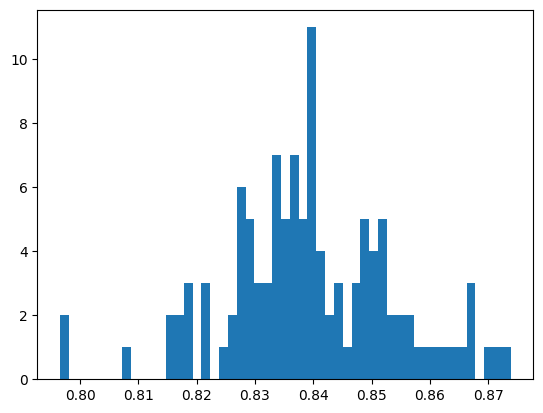

In [22]:
'''Here are the confidences of all tracks. The two track events have lower confidences in their predictions
than average'''
plt.hist(yolo['prob'],bins=51);

### Let's plot an example output

In [50]:
#Assumes test dataframe is called df and yolo results are called yolo
def plot_output(i,zoom): #zoom zooms to truth frame
    tmp = df.iloc[i]
    tmpyolo = grp.query('frame == %s'%(i))
    '''Use vignetted_q with noise, otherwise q'''
    try:
        im = np.histogram2d(tmp['x'],tmp['y'],weights=tmp['q'],bins=(2048,1152),range=((0,2048),(0,1152)))[0].T
    except:
        im = np.histogram2d(tmp['x'],tmp['y'],weights=tmp['vignetted_q'],bins=(2048,1152),range=((0,2048),(0,1152)))[0].T
    plt.imshow(im,cmap='viridis')
    
    #Truth bounding box in white
    plt.hlines(tmp['ymin'],tmp['xmin'],tmp['xmax'],color='w',lw=2)
    plt.hlines(tmp['ymax'],tmp['xmin'],tmp['xmax'],color='w',lw=2)
    plt.vlines(tmp['xmin'],tmp['ymin'],tmp['ymax'],color='w',lw=2)
    plt.vlines(tmp['xmax'],tmp['ymin'],tmp['ymax'],color='w',lw=2)
    
    for xmin,xmax,ymin,ymax in zip(tmpyolo['xmin'],tmpyolo['xmax'],tmpyolo['ymin'],tmpyolo['ymax']):
        #Predicted bounding boxes in cyan
        plt.hlines(ymin,xmin,xmax,color='cyan',lw=2)
        plt.hlines(ymax,xmin,xmax,color='cyan',lw=2)
        plt.vlines(xmin,ymin,ymax,color='cyan',lw=2)
        plt.vlines(xmax,ymin,ymax,color='cyan',lw=2)
    
    if zoom:
        plt.xlim(tmp['xmin']-15,tmp['xmax']+15)
        plt.ylim(tmp['ymin']-15,tmp['ymax']+15)
    
    #Truth keypoints in white, predicted keypoints in cyan
    for i in range(0,conf['maxNumKeyPoints']):
        if i == 0:
            plt.plot(tmp['p%sx'%(i)],tmp['p%sy'%(i)],'o',color='k')
            for x,y in zip(tmpyolo['p%sx'%(i)],tmpyolo['p%sy'%(i)]):
                plt.plot(x,y,'o',color='magenta')
        else:
            plt.plot(tmp['p%sx'%(i)],tmp['p%sy'%(i)],'o',color='w')
            for x,y in zip(tmpyolo['p%sx'%(i)],tmpyolo['p%sy'%(i)]):
                plt.plot(x,y,'o',color='cyan')
    
    plt.show()

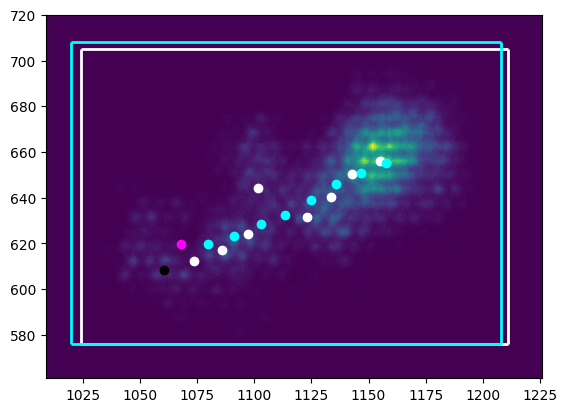

In [24]:
'''Recall when assessing the results that our model was trained on noisy image. The images shown here
are the truth ERs without noise (I didn't save the noise in the processing)'''

plot_output(18,zoom = True)

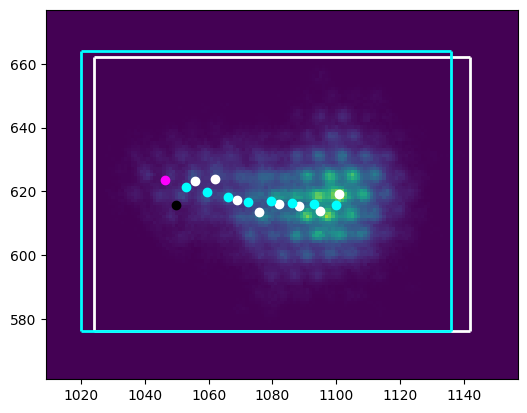

In [25]:
'''Here"s one with two tracks'''
plot_output(73,zoom = True)

# Let's quantify our performance

We'll start with bounding box quantification. We use the IOU which stands for "intersection over union" metric. This metric is the ratio of the areas of the intersection to union of the truth and predicted bounding boxes. Perfect overlap is 1, no overlap is 0

![](../../figures/IOU_def.png)

In [26]:
def bb_intersection_over_union(xmin1, xmax1, ymin1, ymax1, xmin2, xmax2, ymin2, ymax2):
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(xmin1, xmin2)
    yA = max(ymin1, ymin2)
    xB = min(xmax1, xmax2)
    yB = min(ymax1, ymax2)
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # compute the area of both the prediction and ground-truth rectangles
    
    boxAArea = (xmax1 - xmin1 + 1) * (ymax1 - ymin1 + 1)
    boxBArea = (xmax2 - xmin2 + 1) * (ymax2 - ymin2 + 1)
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area so we don't double count the intersection
    
    iou = interArea / (boxAArea + boxBArea - interArea)

    return iou

In [27]:
IOUs = []
for i in range(0,len(df)):
    tmp = df.iloc[i]
    tmpyolo = yolo.query('frame == %s'%(i))
    if len(tmpyolo) != 1:
        IOU = -1
    else:
        tmpyolo = tmpyolo.iloc[0]
        IOU = bb_intersection_over_union(tmp['xmin'], tmp['xmax'], tmp['ymin'], tmp['ymax'], 
                                     tmpyolo['xmin'], tmpyolo['xmax'], tmpyolo['ymin'], tmpyolo['ymax'])
    IOUs.append(IOU)

In [28]:
metrics = pd.DataFrame()
metrics['IOU'] = IOUs

(array([          0,           0,           0,           0,           0,           0,           0,           1,          40,          72]),
 array([          0,         0.1,         0.2,         0.3,         0.4,         0.5,         0.6,         0.7,         0.8,         0.9,           1]),
 <BarContainer object of 10 artists>)

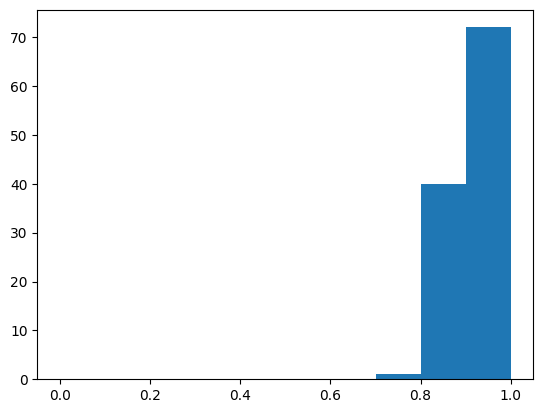

In [29]:
# Let's visualize our IOU scores

plt.hist(metrics['IOU'],range=(0,1))

In [30]:
### Need to add IOU to grp. We'll just remake grp to do this...in an analysis with much larger datasets you want
### to be more careful about when to do large operations, but here we have very small datasets, so it's okay

grp = yolo.groupby('frame').agg(list).reset_index()

In [31]:
# Generally speaking our IOUs look great. Lets see what the best and worst overlapping events look like

worstIOUidx = metrics['IOU'].nsmallest(1).index.to_numpy()[0]
bestIOUidx = metrics['IOU'].nlargest(1).index.to_numpy()[0]

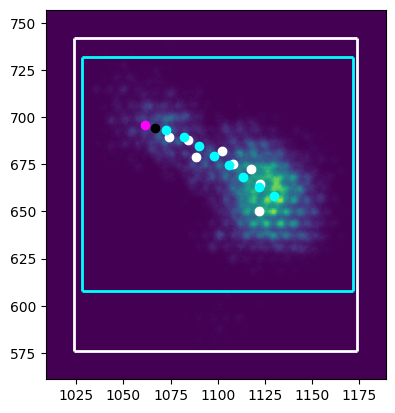

In [32]:
plot_output(worstIOUidx,zoom = True)

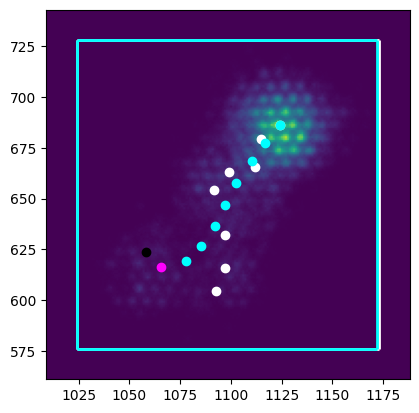

In [33]:
plot_output(bestIOUidx,zoom = True)

# Next lets assess our keypoint detection performance
Coming up with a good metric to holistically assess keypoint assignments is important, and there's a good deal of flexibilty of how to come up with one. Genreally speaking, with ML metrics, we want something that ranges from 0 to 1 with 0 being maximally bad and 1 being maximally good. The computer vision community often uses a metric called [object keypoint similarity](https://learnopencv.com/object-keypoint-similarity/), which satisfies these criteria. We'll use a simplified version of object keypoint similarity and begin by defining the keypoint similarity of point $i$ as
$$
KS_{i} = \exp\left(\frac{-d_i^2}{2s^2k^2}\right),
$$

where $d_i$ is the Euclidean distance between point the truth and predicted keypoint $i$, $s$ is a scale parameter defined as the area of the truth bounding box, and $k$ is an empirically determined constant. For an image we'll compute the object keypoint similarity, $\rm OKS$, as
$$
\mathrm{OKS}=\frac{1}{N_\mathrm{keypoints}}\sum_{i=1}^{N_\mathrm{keypoints}}KS_i
$$

**Important, OKS is an ordered quantity. The order of the keypoints determined by YOLO is supposed to match the truth ordering. For applications where direction matters, we want OKS to be order dependent. If we don't care about direction, we can reorder the points before computing OKS in such a way that it minimizes the Euclidean distance.**

In [34]:
'''Define a function for order-dependents OKS between truth and measured'''
def order_dependent_OKS(truth,meas,k): #arguments are two tracks which we can think of as rows of dataframes
    distances = []
    for i in range(0,conf['maxNumKeyPoints']): #Loop through each point in the event
        d = np.sqrt((meas['p%sx'%(i)]-truth['p%sx'%(i)])**2+(meas['p%sy'%(i)]-truth['p%sy'%(i)])**2)
        distances.append(d)
    scale = truth['width']*truth['height'] #This is s, we'll compute truth bounding box relative to image size for this
    OKS = np.exp(-1*(np.array(distances)**2)/(2*scale**2*k**2)).sum()/conf['maxNumKeyPoints']
    print(OKS)
    return OKS

In [35]:
'''Compute OKS'''
OKSs = []
for i in range(0,len(df)):
    tmp = df.iloc[i]
    tmpyolo = yolo.query('frame == %s'%(i))
    if len(tmpyolo) != 1:
        OKS = -1
    else:
        tmpyolo = tmpyolo.iloc[0]
        OKS = order_dependent_OKS(tmp,tmpyolo,k=0.001)
    OKSs.append(OKS)

0.9121433140990935
0.8732999923511012
0.9233081944407652
0.9353885750608681
0.9656011107069151
0.916798161456962
0.9766059553291438
0.8852771745190888
0.896520360059298
0.9090142307866191
0.32819233734733755
0.8919382141425606
0.9410624365553344
0.9223349935238156
0.9262652003672862
0.9765068220807515
0.9694022274314616
0.9326887424535594
0.9271517446824397
0.8238206618919838
0.9114781905413349
0.9371513647620782
0.927653276659005
0.9296638109751236
0.8293830712689342
0.5899020066572176
0.9602356278654551
0.8380157633699343
0.9644064280123948
0.9647427436613805
0.9201788273585217
0.5425187161375437
0.9053816113323278
0.8717104459372244
0.8429928115281419
0.9658274689867492
0.942077837571074
0.8395049425384847
0.9367636152646666
0.9338132154341687
0.942769201800686
0.8992561039892214
0.9552362501433649
0.8455213695951804
0.9043550071617916
0.9295169393359058
0.9583727993470595
0.972435031894674
0.737162887084416
0.8839914963809665
0.9120962938322125
0.7542782097079929
0.9515425721178414

In [36]:
'''Add OKS to the metrics dataframe'''
metrics['OKS'] = OKSs

(array([          0,           0,           0,           1,           0,           2,           1,           6,          31,          72]),
 array([          0,         0.1,         0.2,         0.3,         0.4,         0.5,         0.6,         0.7,         0.8,         0.9,           1]),
 <BarContainer object of 10 artists>)

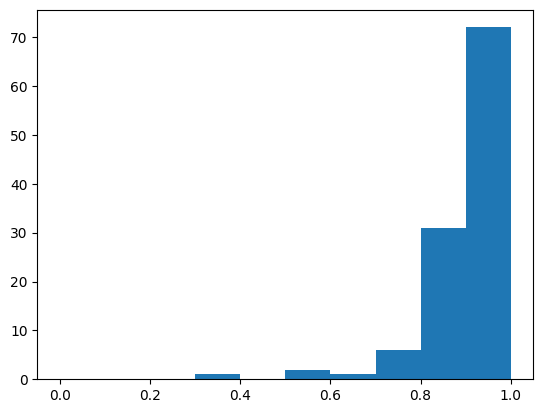

In [37]:
plt.hist(metrics['OKS'],range=(0,1))

In [38]:
metrics.query('OKS > 0')['OKS'].mean()

0.8964661708964508

In [51]:
# Let's see what the best and worst keypoint images look like

worstOKSidx = metrics.query('OKS > 0')['OKS'].nsmallest(2).index.to_numpy()[1]
avgOKSidxs = metrics.query('0.9 > OKS > 0.88')['OKS'].nsmallest(10).index.to_numpy()
bestOKSidx = metrics['OKS'].nlargest(1).index.to_numpy()[0]

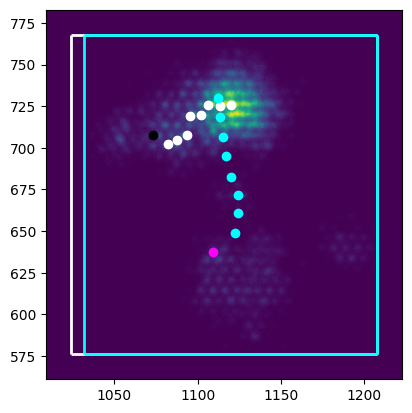

In [52]:
plot_output(worstOKSidx,zoom = True)

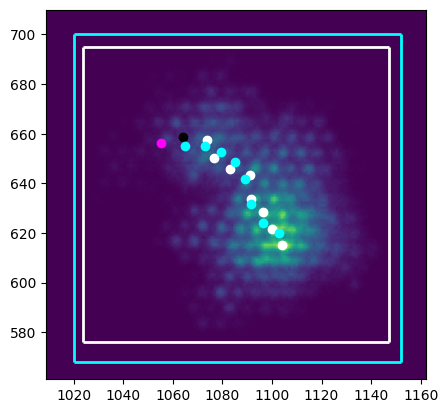

In [53]:
plot_output(avgOKSidxs[0],zoom = True)

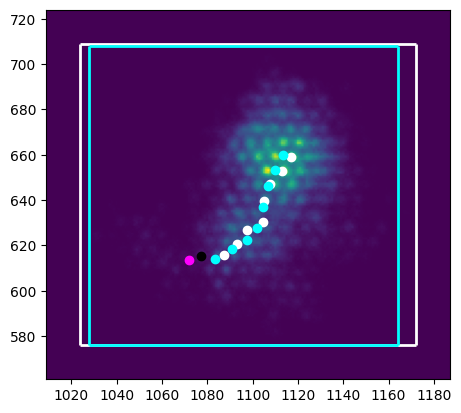

In [43]:
plot_output(bestOKSidx,zoom = True)

# A few other things we can do:
1. Repeat this exercise for images with multiple tracks (great way to play around with more realistic data sets!)
2. Compute a head/tail OKS score only considering head and tail points. Then you can compare the OKS with the order YOLO gave versus the reverse order. This would be more interesting in a more diverse set where we get head/tail wrong sometimes
3. Assess how good the heads and tails individually were assessed
4. Repeat these notebooks with more realistic simulation that includes Noise (Done)
5. Play around with estimating track angles based on keypoint trajectories and comparing to truth

### We now have a starting point for labeling data. We can use our pretrained model and test how it works when labeling data in Label Studio